# Linear Regression

# 1.  Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, coint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

In [2]:
# importing bitcoin price data
df = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btc_clean.csv', index_col = False)

In [3]:
# Print first few rows to check the data format
print("First few rows of data:")
print(df.head())
print(f"\nColumns: {df.columns.tolist()}")
print(f"Timestamp dtype: {df['Timestamp'].dtype}")

First few rows of data:
      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0

Columns: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
Timestamp dtype: float64


In [4]:
# Convert Unix timestamp to datetime

df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

In [5]:
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
1,2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2,2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
3,2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
4,2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [6]:
df.to_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btc_clean_2.csv', index=False)

In [75]:
df = df.sort_values('Timestamp')

In [76]:
# Create time variable: days since first observation
df['days_since_start'] = (df['Timestamp'] - df['Timestamp'].min()).dt.days + 1  # +1 to avoid log(0)

print(f"Days range: {df['days_since_start'].min()} to {df['days_since_start'].max()}")

Days range: 1 to 5017


In [88]:
# Remove any rows with missing or zero prices (using Close column)
print(f"\nRows before filtering: {len(df)}")
print(f"Close price range: ${df['Close'].min():.2f} to ${df['Close'].max():.2f}")
df = df[(df['Close'] > 0) & (df['Close'].notna())]
print(f"Rows after filtering: {len(df)}")

if len(df) == 0:
    raise ValueError("No valid data after filtering! Check if Close column has valid prices.")



Rows before filtering: 7222717
Close price range: $3.80 to $124482.00
Rows after filtering: 7222717


In [90]:
# Transform to log space for power law analysis
# Power law: price = a * time^b
# Log transformation: log(price) = log(a) + b * log(time)
df['log_days'] = np.log10(df['days_since_start'])
df['log_price'] = np.log10(df['Close'])

print(f"\nLog transformation complete:")
print(f"log_days range: {df['log_days'].min():.4f} to {df['log_days'].max():.4f}")
print(f"log_price range: {df['log_price'].min():.4f} to {df['log_price'].max():.4f}")



Log transformation complete:
log_days range: 0.0000 to 3.7004
log_price range: 0.5798 to 5.0951


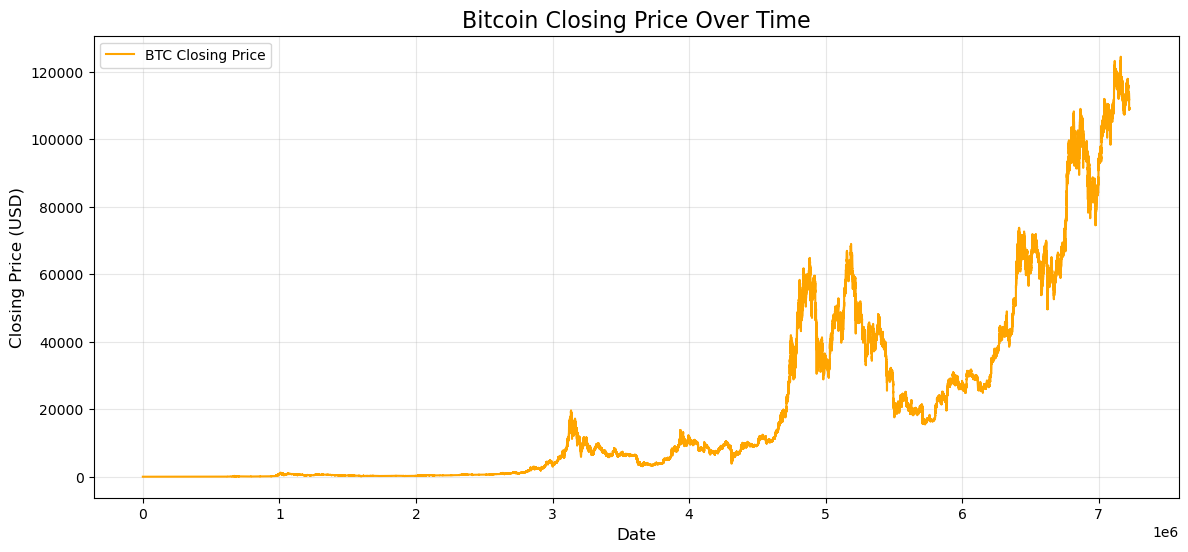

In [91]:
# Plot closing price
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'], label='BTC Closing Price', color='orange')

# Add labels & title
plt.title("Bitcoin Closing Price Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Closing Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# 2. Preparing for regression

In [92]:
# Prepare data for regression
X = df['log_days'].values.reshape(-1, 1)
y = df['log_price'].values

print(f"\nRegression data prepared:")
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X sample: {X[:3].flatten()}")
print(f"y sample: {y[:3]}")


Regression data prepared:
X shape: (7222717, 1), y shape: (7222717,)
X sample: [0. 0. 0.]
y sample: [0.66086548 0.66086548 0.66086548]


In [93]:
# Create and fit the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [94]:
# Make predictions
y_pred = model.predict(X)

In [95]:
# Calculate metrics
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

In [96]:
# Extract power law parameters
# log(price) = intercept + slope * log(time)
# price = 10^intercept * time^slope
a = 10 ** model.intercept_  # coefficient
b = model.coef_[0]  # exponent

In [97]:
# Print results
print("=" * 60)
print("POWER LAW REGRESSION RESULTS")
print("=" * 60)
print(f"\nPower Law Model: Price = {a:.6f} × Days^{b:.4f}")
print(f"\nR² Score: {r2:.4f}")
print(f"RMSE (log space): {rmse:.4f}")
print(f"\nExponent (b): {b:.4f}")

if r2 > 0.85:
    print("\n✓ Strong power law relationship detected!")
    print("  Bitcoin price growth appears to follow a power law.")
elif r2 > 0.70:
    print("\n~ Moderate power law relationship detected.")
    print("  Bitcoin price shows some power law characteristics.")
else:
    print("\n✗ Weak power law relationship.")
    print("  Bitcoin price may not follow a clear power law.")

POWER LAW REGRESSION RESULTS

Power Law Model: Price = 0.000020 × Days^2.5099

R² Score: 0.8554
RMSE (log space): 0.4462

Exponent (b): 2.5099

✓ Strong power law relationship detected!
  Bitcoin price growth appears to follow a power law.


In [98]:
# Make future predictions (optional)
# Predict for next 365 days
future_days = np.arange(df['days_since_start'].max() + 1, 
                        df['days_since_start'].max() + 366)
future_log_days = np.log10(future_days).reshape(-1, 1)
future_log_price = model.predict(future_log_days)
future_price = 10 ** future_log_price

print(f"\nFuture Prediction (1 year from last data point):")
print(f"Predicted price: ${future_price[-1]:,.2f}")



Future Prediction (1 year from last data point):
Predicted price: $45,295.91


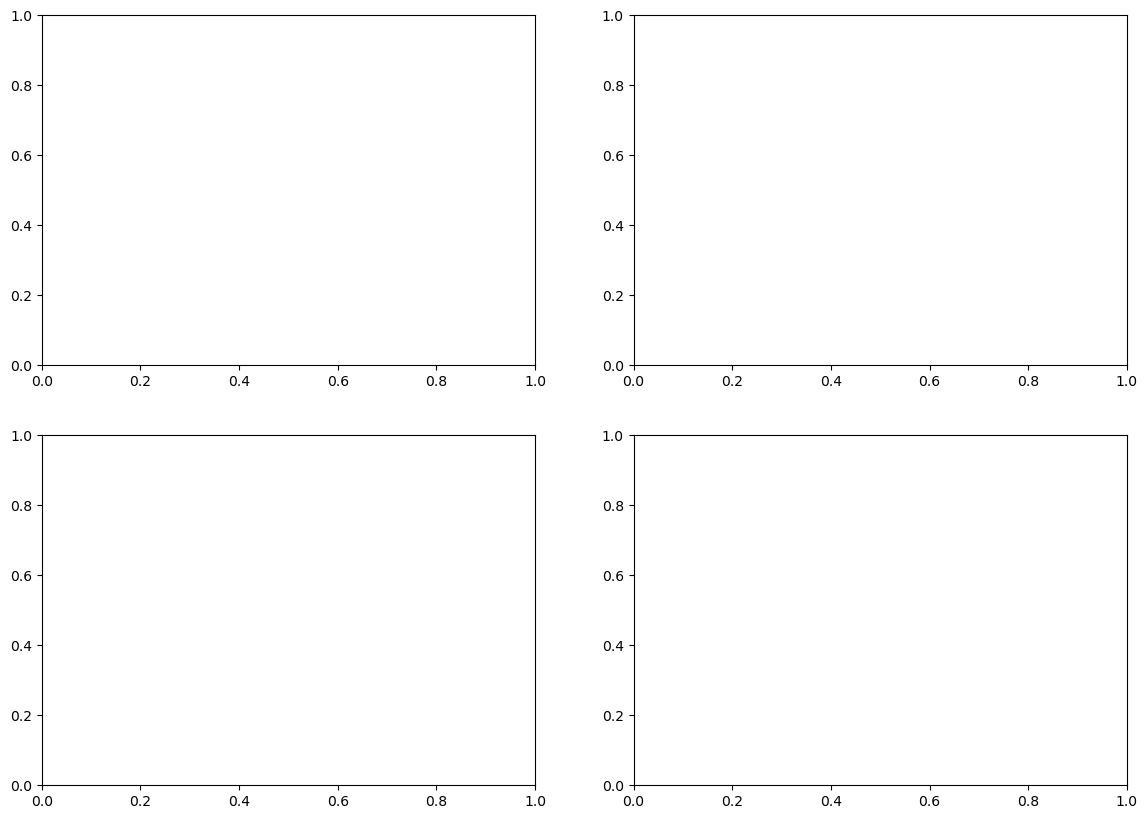

In [99]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

In [68]:
# 1. Actual price over time
axes[0, 0].plot(df['Timestamp'], df['Close'], 'b-', alpha=0.6, linewidth=1)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].set_title('Bitcoin Price Over Time')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

In [69]:
# 2. Log-log plot with regression line
axes[0, 1].scatter(df['log_days'], df['log_price'], alpha=0.5, s=10)
axes[0, 1].plot(df['log_days'], y_pred, 'r-', linewidth=2, label='Power Law Fit')
axes[0, 1].set_xlabel('Log₁₀(Days Since Start)')
axes[0, 1].set_ylabel('Log₁₀(Price)')
axes[0, 1].set_title(f'Power Law Fit (R² = {r2:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

In [70]:
# 3. Residuals plot
residuals = y - y_pred
axes[1, 0].scatter(y_pred, residuals, alpha=0.5, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Log₁₀(Price)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

In [71]:
# 4. Actual vs Predicted (in original scale)
actual_price = df['Close'].values
pred_price = 10 ** y_pred
axes[1, 1].scatter(actual_price, pred_price, alpha=0.5, s=10)
axes[1, 1].plot([actual_price.min(), actual_price.max()], 
                [actual_price.min(), actual_price.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Price (USD)')
axes[1, 1].set_ylabel('Predicted Price (USD)')
axes[1, 1].set_title('Actual vs Predicted Price')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bitcoin_power_law_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("Analysis complete! Chart saved as 'bitcoin_power_law_analysis.png'")
print("=" * 60)

<Figure size 640x480 with 0 Axes>


Analysis complete! Chart saved as 'bitcoin_power_law_analysis.png'
